$$
\Huge \blue{\textbf{Distribution shift \qquad}} \\
$$

# $\text{Analysis of different models over shifted datasets}$

## $\text{Imports \& settings}$

In [9]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    classification_report, roc_auc_score, accuracy_score, 
    f1_score, roc_curve
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from scipy.stats import ortho_group

from src.analysis import evaluate_models_on_shifts, compare_adversarial_training
from src.utils import *
from src.plotting import visualize_feature_shifts

np.random.seed(0)


In [16]:
DATA_FOLDER = 'data'

 # 3. Visualization for n-Dimensional Data



 For higher dimensional data (n > 2), we can either:

 - Visualize a pairwise scatter matrix (e.g., `sns.pairplot`) for a subset of features.

 - Or just visualize a specified pair of features for a quick glimpse.

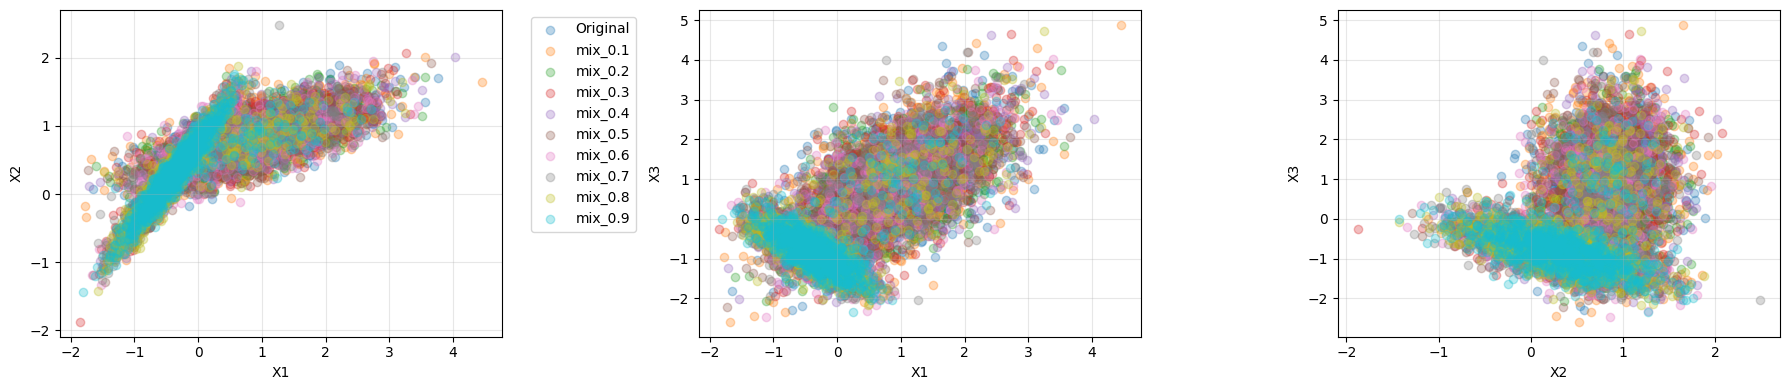

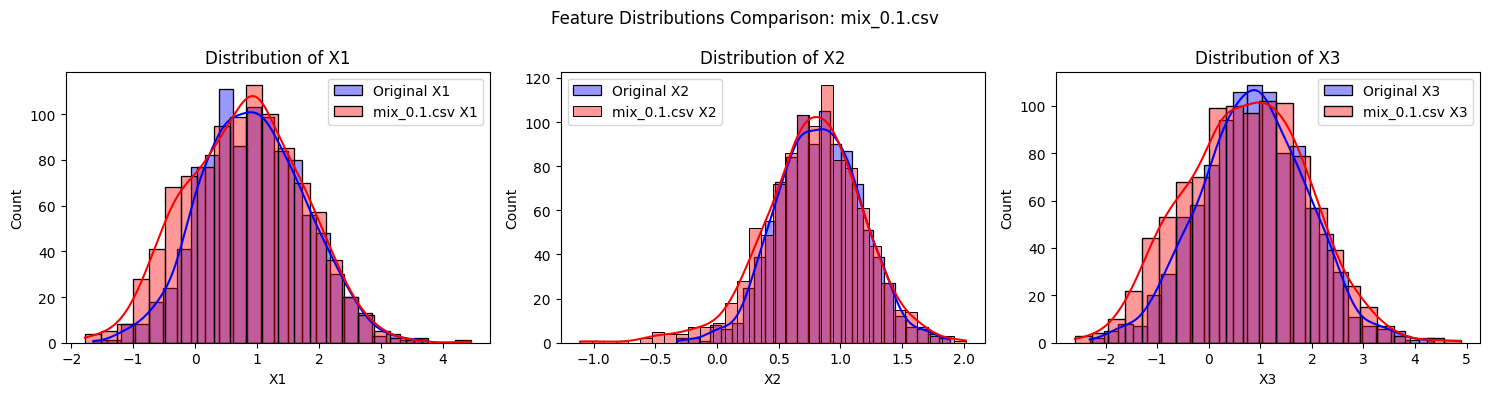

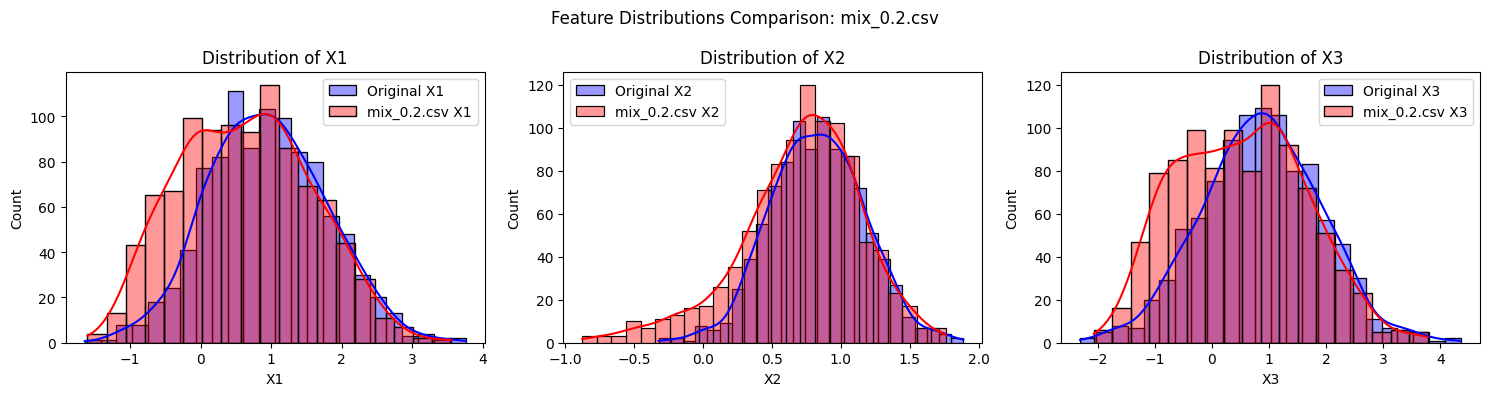

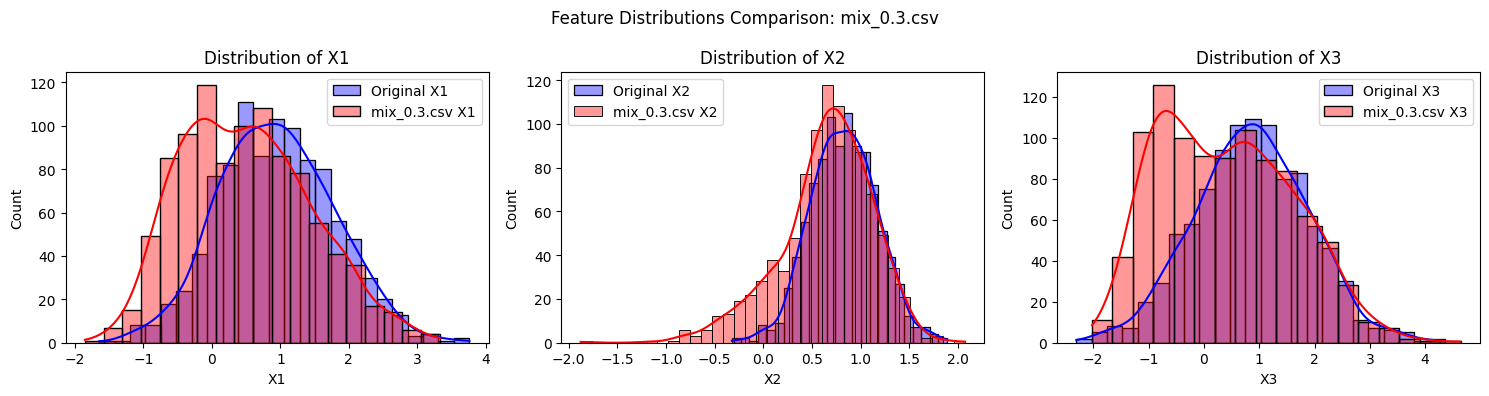

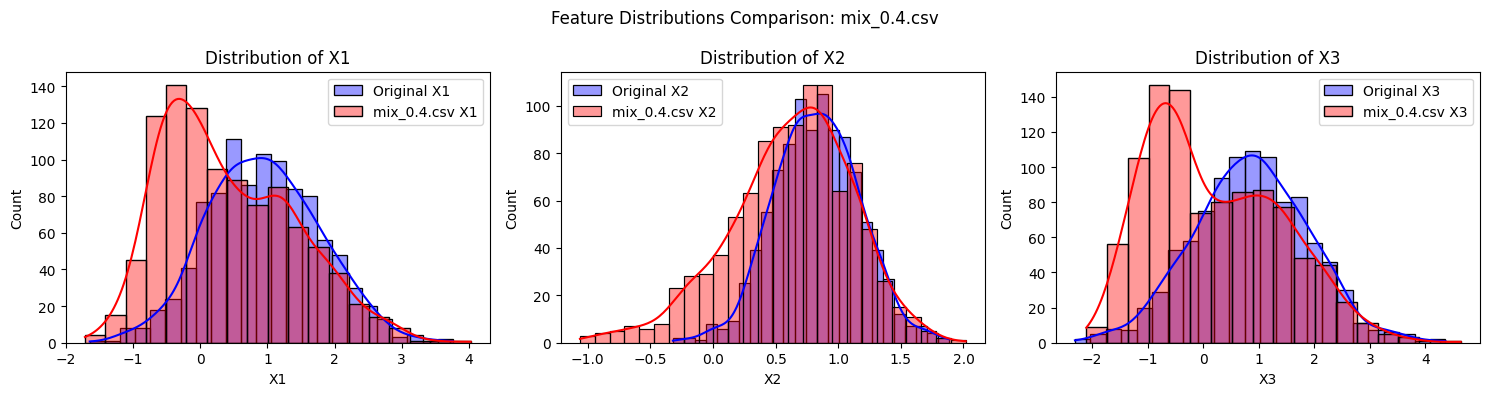

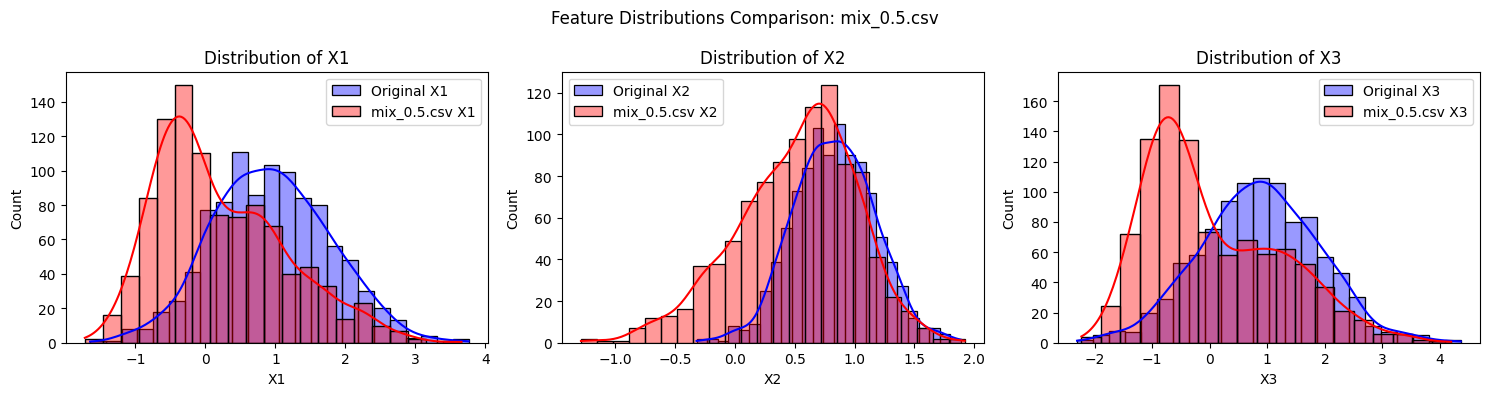

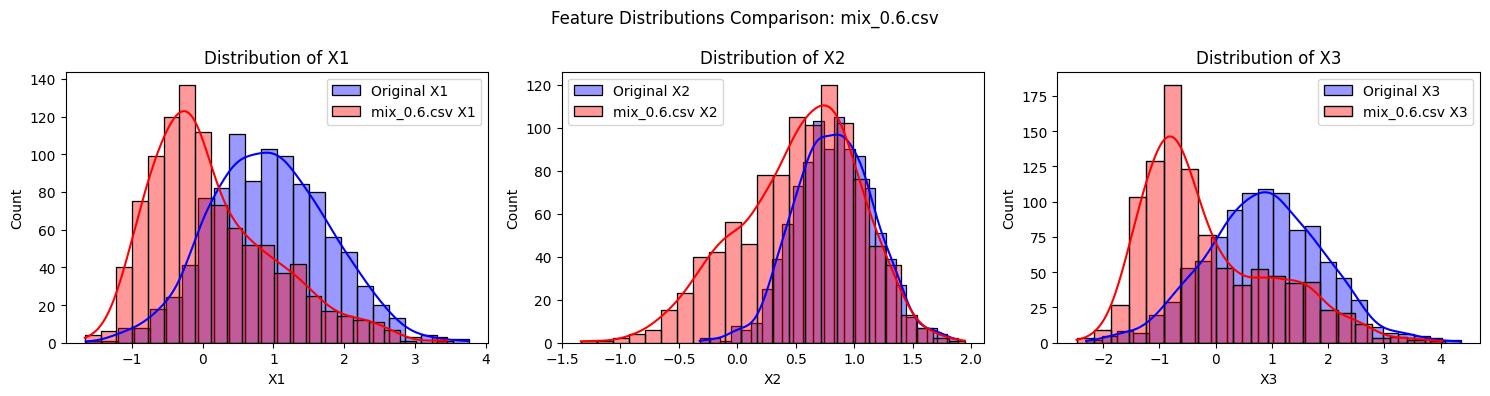

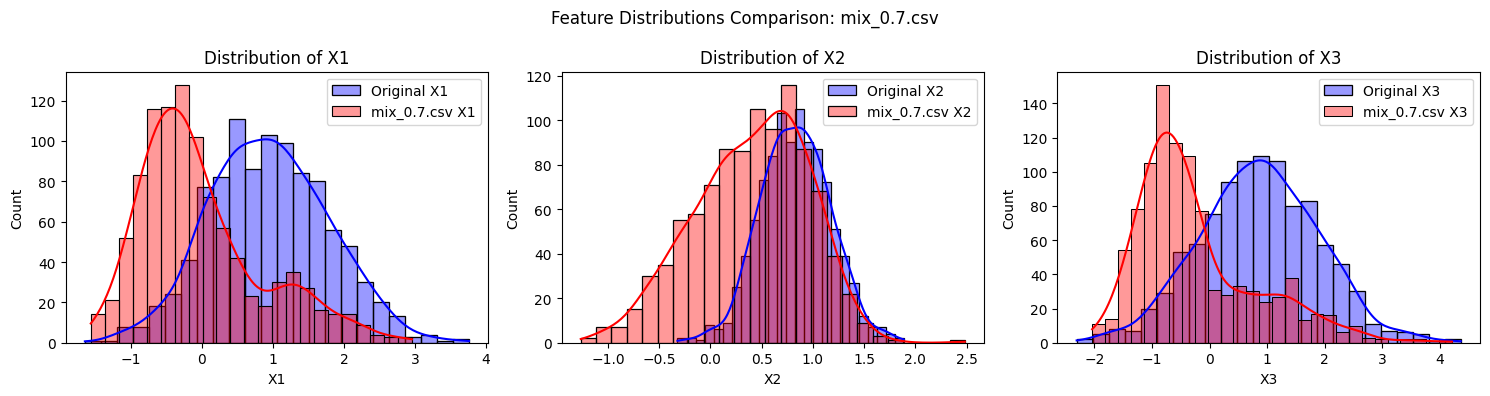

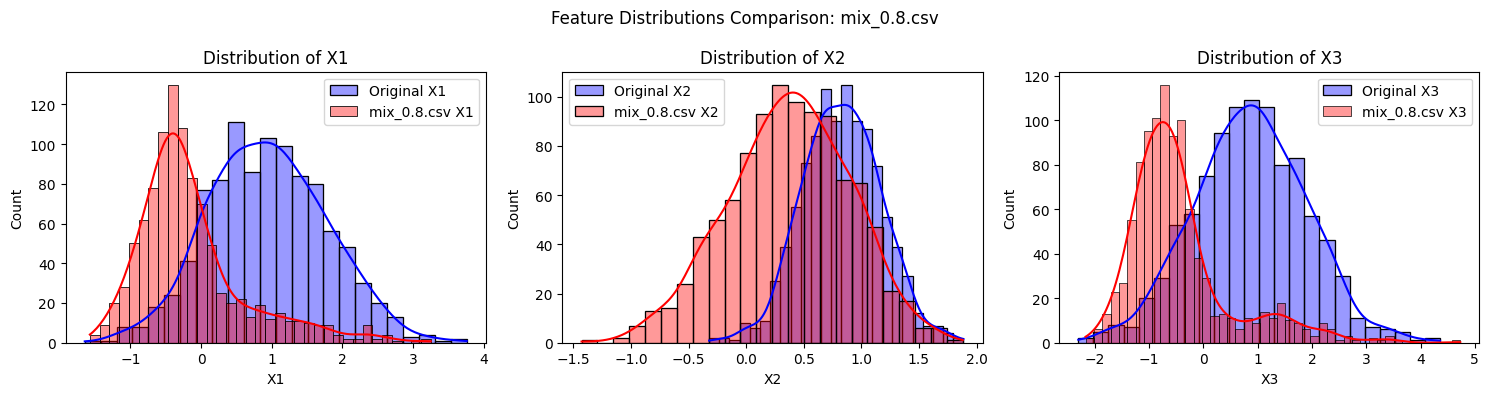

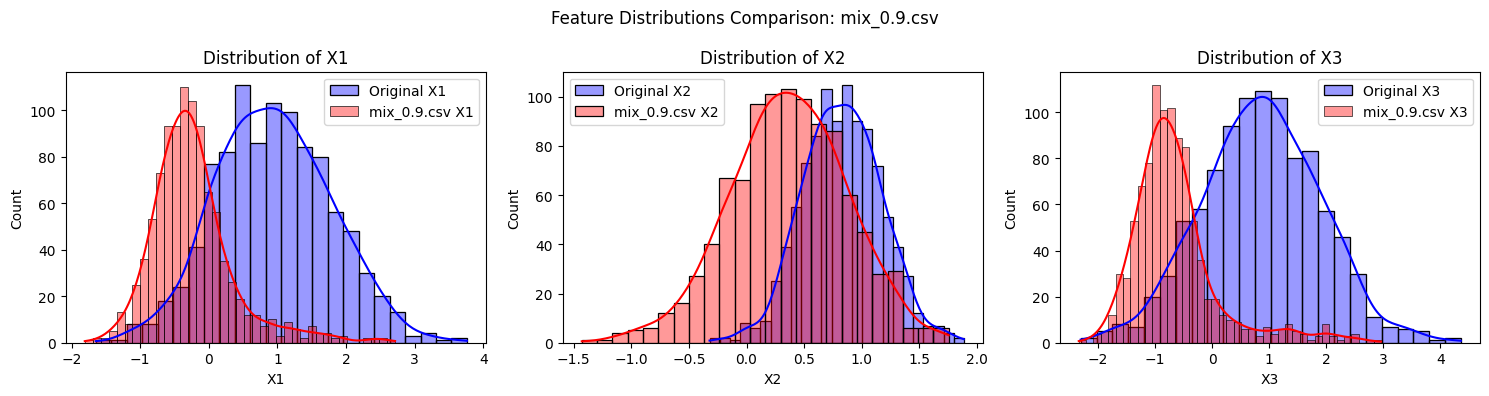

In [17]:
visualize_feature_shifts(folder = DATA_FOLDER, features_to_plot= ['X1', 'X2', 'X3'])

## Fit a Decision Tree and a Gradient Boosting Classifier

In [18]:
# Load original => train data
df_orig = pd.read_csv(os.path.join(DATA_FOLDER, "train.csv"))
X_train = df_orig.drop('Y', axis=1)
y_train = df_orig['Y']

# Fit Decision Tree
model_1 = DecisionTreeClassifier(
  max_depth=4,
  min_samples_leaf=13
)

model_1.fit(X_train, y_train)

# Fit GradientBoosting
model_2 = GradientBoostingClassifier(
    learning_rate=0.05,
    max_depth=4,
    max_features='log2',
    min_samples_leaf=13,
    n_estimators=100,
    subsample=0.7
)

model_2.fit(X_train, y_train)

models = {
  "DecisionTreeClassifier" : model_1,
  "GradientBoostingClassifier" : model_2}

 ### Baseline Model Evaluation Across Shifts (General n_features)

=== DecisionTreeClassifier on mix_0.1.csv ===
Accuracy: 0.782, F1: 0.784, AUC: 0.859
              precision    recall  f1-score   support

           0       0.74      0.83      0.78       469
           1       0.83      0.74      0.78       531

    accuracy                           0.78      1000
   macro avg       0.78      0.78      0.78      1000
weighted avg       0.79      0.78      0.78      1000

---------------------------------------------------
=== DecisionTreeClassifier on mix_0.2.csv ===
Accuracy: 0.771, F1: 0.741, AUC: 0.830
              precision    recall  f1-score   support

           0       0.74      0.85      0.79       520
           1       0.81      0.68      0.74       480

    accuracy                           0.77      1000
   macro avg       0.78      0.77      0.77      1000
weighted avg       0.78      0.77      0.77      1000

---------------------------------------------------
=== DecisionTreeClassifier on mix_0.3.csv ===
Accuracy: 0.770, F1: 0.722

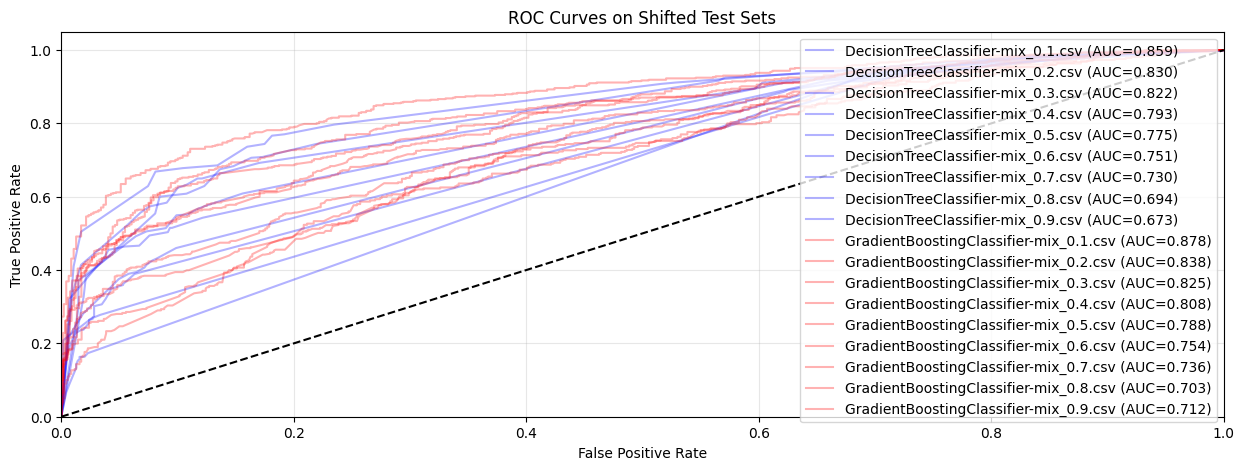

In [19]:
evaluate_models_on_shifts(models)

 # 5. Adversarial Training for GradientBoosting (General n_features)

 ### Compare Normal vs. Adversarial Training on Shifted Sets

In [6]:
compare_adversarial_training(DATA_FOLDER)


=== Evaluate Normal vs. Adversarially Trained Model ===

Shifted file: mix_0.1.csv
  Normal Model   => Acc: 0.750, F1: 0.740, AUC: 0.824
  AdvTrain Model => Acc: 0.754, F1: 0.728, AUC: 0.819
---------------------------------------------------
Shifted file: mix_0.2.csv
  Normal Model   => Acc: 0.734, F1: 0.750, AUC: 0.824
  AdvTrain Model => Acc: 0.746, F1: 0.748, AUC: 0.831
---------------------------------------------------
Shifted file: mix_0.3.csv
  Normal Model   => Acc: 0.787, F1: 0.820, AUC: 0.863
  AdvTrain Model => Acc: 0.792, F1: 0.814, AUC: 0.873
---------------------------------------------------
Shifted file: mix_0.4.csv
  Normal Model   => Acc: 0.804, F1: 0.842, AUC: 0.888
  AdvTrain Model => Acc: 0.815, F1: 0.845, AUC: 0.897
---------------------------------------------------
Shifted file: mix_0.5.csv
  Normal Model   => Acc: 0.807, F1: 0.857, AUC: 0.887
  AdvTrain Model => Acc: 0.810, F1: 0.852, AUC: 0.895
---------------------------------------------------
Shifted file

 # 6. Mechanistic-Interpretability-Guided Robust Boosting

In [7]:
def mech_interp_boosting(
    X_train: pd.DataFrame,
    y_train: pd.Series,
    target = 'Y',
    base_model=None,
    base_shift_factor: float = 0.1,
    n_rounds: int = 2,
    fraction_to_shift: float = 0.3,
    min_improvement: float = 0.001,
    noise_scale: float = 0.01,
    n_features_to_shift: int = 1,
    final_train_size: int = None,
    use_weighted_fit: bool = False,
    random_state: int = 42
):
    """
    Improved Mechanistic-Interpretability-Guided Robust Boosting.
    
    Changes:
      1) Per-round, only shift a fraction of samples (fraction_to_shift).
      2) Weighted training (optional): shift data can have a higher sample_weight, 
         so the model doesn't need an even bigger dataset but still focuses on them.
      3) Repeated smaller shift_factor, combined with early stopping on a validation set.
      4) Final downsampling to ensure fair #samples vs. baseline.

    Parameters
    ----------
    X_train, y_train : pd.DataFrame, pd.Series
        Original data
    base_model : fitted or None
        If None, a new GradientBoostingClassifier is created.
    base_shift_factor : float
        Initial magnitude of shift for the selected features.
    n_rounds : int
        Max number of augmentation rounds.
    fraction_to_shift : float
        Fraction of samples to shift each round.
    min_improvement : float
        Minimum improvement in validation for continuing rounds.
    noise_scale : float
        Std dev of random noise added to each shifted sample.
    n_features_to_shift : int
        # of top features to shift.
    final_train_size : int or None
        If not None, downsample the final augmented set to this size.
    use_weighted_fit : bool
        If True, we apply sample weights that are higher for newly shifted samples.
    random_state : int
        Reproducibility seed.

    Returns
    -------
    model : GradientBoostingClassifier
        The final robust model after all rounds.
    X_final, y_final : final training set used to fit (with or without weighting).
    """

    rng = np.random.RandomState(random_state)
    
    if base_model is None:
        base_model = GradientBoostingClassifier(
            learning_rate=0.05,
            max_depth=4,
            max_features='log2',
            min_samples_leaf=13,
            n_estimators=100,
            subsample=0.7,
            random_state=random_state
        )

    # Train/Val split
    X_tr, X_val, y_tr, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=random_state
    )

    # This is the growing augmented set
    X_aug = X_tr.copy()
    y_aug = y_tr.copy()
    # (optional) Keep track of sample weights
    sample_weights = np.ones(len(X_aug))  # default weight=1

    best_val_score = 0.0
    rounds_without_improvement = 0
    
    for round_idx in range(n_rounds):
        # Fit the model with or without weighting
        if use_weighted_fit:
            base_model.fit(X_aug, y_aug, sample_weight=sample_weights)
        else:
            base_model.fit(X_aug, y_aug)
        
        val_score = base_model.score(X_val, y_val)
        print(f"[Round {round_idx+1}] Validation Score = {val_score:.3f}")

        # Early stopping check
        if val_score > best_val_score + min_improvement:
            best_val_score = val_score
            rounds_without_improvement = 0
        else:
            rounds_without_improvement += 1
            if rounds_without_improvement >= 3:
                print(f"Early stopping at round {round_idx+1}")
                break

        # SHIFT SAMPLES:
        # Only shift fraction_to_shift portion of the data
        n_current = len(X_aug)
        subset_size = int(fraction_to_shift * n_current)
        idx_to_shift = rng.choice(n_current, size=subset_size, replace=False)
        
        shift_list = []
        label_list = []
        weight_list = []

        current_shift_factor = base_shift_factor * (0.9 ** round_idx)
        
        #print("ciao")
        
        for i in idx_to_shift:
            
            x_i = X_aug.iloc[i].values.copy()
            label_i = y_aug.iloc[i]
            
            # Compute approximate gradient-based feature importance
            # Probability of correct label
            df_x_i = pd.DataFrame(x_i.reshape(1, -1), columns=X_tr.columns)
            prob_original = base_model.predict_proba(df_x_i)[0][label_i]

            feature_scores = []
            for feat_idx in range(len(x_i)):
                x_pos = x_i.copy()
                x_neg = x_i.copy()
                x_pos[feat_idx] += 1e-3
                x_neg[feat_idx] -= 1e-3
                df_x_pos = pd.DataFrame(x_pos.reshape(1, -1), columns=X_tr.columns)
                df_x_neg = pd.DataFrame(x_neg.reshape(1, -1), columns=X_tr.columns)
                prob_pos = base_model.predict_proba(df_x_pos)[0][label_i]
                prob_neg = base_model.predict_proba(df_x_neg)[0][label_i]
                grad_est = (prob_pos - prob_neg) / (2e-3)
                feature_scores.append(abs(grad_est))
            
            top_feats = np.argsort(feature_scores)[-n_features_to_shift:]
            
            shift_dir = np.zeros_like(x_i)
            for feat_idx in top_feats:
                # Recompute sign(grad) to see which direction lowers prob
                x_pos[feat_idx] = x_i[feat_idx] + 1e-3
                x_neg[feat_idx] = x_i[feat_idx] - 1e-3
                df_x_pos = pd.DataFrame(x_pos.reshape(1, -1), columns=X_tr.columns)
                df_x_neg = pd.DataFrame(x_neg.reshape(1, -1), columns=X_tr.columns)
                prob_pos = base_model.predict_proba(df_x_pos)[0][label_i]
                prob_neg = base_model.predict_proba(df_x_neg)[0][label_i]
                actual_grad = (prob_pos - prob_neg) / (2e-3)
                direction_sign = -1 if actual_grad > 0 else 1
                shift_dir[feat_idx] = direction_sign
            noise = rng.normal(0, noise_scale, size=len(x_i))
            x_shifted = x_i + shift_dir * current_shift_factor + noise
            
            shift_list.append(x_shifted)
            label_list.append(label_i)
            if use_weighted_fit:
                # e.g., give a slightly higher weight, so model focuses on these new shifted points
                weight_list.append(2.0)  # shift points weight=2.0
            else:
                weight_list.append(1.0)

        # Augment
        df_shifted = pd.DataFrame(shift_list, columns=X_tr.columns)
        s_labels = pd.Series(label_list, name=target)
        
        X_aug = pd.concat([X_aug, df_shifted], ignore_index=True)
        y_aug = pd.concat([y_aug, s_labels], ignore_index=True)
        if use_weighted_fit:
            sample_weights = np.concatenate([sample_weights, np.array(weight_list)])
        else:
            # Keep same weighting for original samples
            sample_weights = np.ones(len(X_aug))

        print(f"  => Added {len(df_shifted)} new shifted samples; total = {len(X_aug)}")

    # Final training set: combine with X_val
    X_final = pd.concat([X_aug, X_val], ignore_index=True)
    y_final = pd.concat([y_aug, y_val], ignore_index=True)

    final_weights = None
    if use_weighted_fit:
        # For simplicity, assume new samples from X_val have weight=1
        w_val = np.ones(len(X_val))
        final_weights = np.concatenate([sample_weights, w_val])
    
    # Downsample to final_train_size
    if final_train_size is not None and final_train_size < len(X_final):
        indices = rng.choice(len(X_final), size=final_train_size, replace=False)
        X_final = X_final.iloc[indices].reset_index(drop=True)
        y_final = y_final.iloc[indices].reset_index(drop=True)
        if final_weights is not None:
            final_weights = final_weights[indices]

    # Final fit
    if use_weighted_fit:
        base_model.fit(X_final, y_final, sample_weight=final_weights)
    else:
        base_model.fit(X_final, y_final)

    return base_model, X_final, y_final


 ### Demo of Mechanistic Boosting on Shifted Data

In [8]:
def demo_mechanistic_robust_boosting(folder: str = "dat", target = 'Y', n_rounds: int = 1):
    """
    Demonstrates the Mechanistic-Interpretability-Guided Robust Boosting 
    approach on 'train.csv' and evaluates it on the shifted CSV files.
    
    Parameters
    ----------
    folder : str, optional
        The folder containing 'train.csv' and 'shifted_*.csv'.
    n_rounds : int, optional
        How many augmentation+retrain rounds to run.
    """
    # 1) Load training data
    df_orig = pd.read_csv(os.path.join(folder, "train.csv"))
    X_train = df_orig.drop(target, axis=1)
    y_train = df_orig[target]
    
    # 2) Baseline GBC for comparison
    gbc_baseline = GradientBoostingClassifier(
        learning_rate=0.05,
        max_depth=4,
        max_features='log2',
        min_samples_leaf=13,
        n_estimators=100,
        subsample=0.7
    )
    gbc_baseline.fit(X_train, y_train)
    
    # 3) Mechanistic interpretability-based boosting
    gbc_mi, X_aug, y_aug = mech_interp_boosting(
        X_train, 
        y_train,
        target = target,
        base_shift_factor=0.2,
        n_rounds=n_rounds,
        min_improvement=0.001,
        noise_scale=0.01,
        n_features_to_shift= 4
    )
    
    test_files = [f for f in os.listdir(folder) if f.startswith("mix_")]
    print(f"\n=== Evaluate Baseline GBC vs. MI-Guided GBC (n_rounds={n_rounds}) on Shifted Data ===\n")
    
    for test_file in test_files:
        df_test = pd.read_csv(os.path.join(folder, test_file))
        X_test = df_test[X_train.columns]
        y_test = df_test[target]
        
        y_pred_b = gbc_baseline.predict(X_test)
        y_proba_b = gbc_baseline.predict_proba(X_test)[:, 1]
        acc_b = accuracy_score(y_test, y_pred_b)
        f1_b = f1_score(y_test, y_pred_b)
        auc_b = roc_auc_score(y_test, y_proba_b)
        
        
        y_pred_m = gbc_mi.predict(X_test)
        y_proba_m = gbc_mi.predict_proba(X_test)[:, 1]
        acc_m = accuracy_score(y_test, y_pred_m)
        f1_m = f1_score(y_test, y_pred_m)
        auc_m = roc_auc_score(y_test, y_proba_m)
        
        print(f"Shifted file: {test_file}")
        print(f"  Baseline GBC => Acc: {acc_b:.3f}, F1: {f1_b:.3f}, AUC: {auc_b:.3f}")
        print(f"  MI-Guided GBC => Acc: {acc_m:.3f}, F1: {f1_m:.3f}, AUC: {auc_m:.3f}")
        print("---------------------------------------------------")



In [10]:
demo_mechanistic_robust_boosting(DATA_FOLDER, n_rounds=1)

[Round 1] Validation Score = 0.765
  => Added 240 new shifted samples; total = 1040

=== Evaluate Baseline GBC vs. MI-Guided GBC (n_rounds=1) on Shifted Data ===

Shifted file: mix_0.3.csv
  Baseline GBC => Acc: 0.783, F1: 0.817, AUC: 0.863
  MI-Guided GBC => Acc: 0.784, F1: 0.814, AUC: 0.864
---------------------------------------------------
Shifted file: mix_0.4.csv
  Baseline GBC => Acc: 0.808, F1: 0.844, AUC: 0.889
  MI-Guided GBC => Acc: 0.811, F1: 0.845, AUC: 0.888
---------------------------------------------------
Shifted file: mix_0.5.csv
  Baseline GBC => Acc: 0.810, F1: 0.859, AUC: 0.886
  MI-Guided GBC => Acc: 0.812, F1: 0.858, AUC: 0.888
---------------------------------------------------
Shifted file: mix_0.2.csv
  Baseline GBC => Acc: 0.734, F1: 0.752, AUC: 0.828
  MI-Guided GBC => Acc: 0.739, F1: 0.746, AUC: 0.829
---------------------------------------------------
Shifted file: mix_0.1.csv
  Baseline GBC => Acc: 0.753, F1: 0.744, AUC: 0.820
  MI-Guided GBC => Acc: 0.7

In [26]:
def train_baseline_gb(
    X_train: pd.DataFrame,
    y_train: pd.Series,
    final_train_size: int = None,
    random_state: int = 42
):
    """
    Train a standard GradientBoosting on exactly 'final_train_size' points 
    (if provided). If final_train_size < len(X_train), downsample first.
    """
    import numpy as np
    from sklearn.ensemble import GradientBoostingClassifier

    rng = np.random.RandomState(random_state)
    
    if final_train_size is not None and final_train_size < len(X_train):
        indices = rng.choice(len(X_train), size=final_train_size, replace=False)
        X_train = X_train.iloc[indices].reset_index(drop=True)
        y_train = y_train.iloc[indices].reset_index(drop=True)
    
    model = GradientBoostingClassifier(
        learning_rate=0.05,
        max_depth=4,
        max_features='log2',
        min_samples_leaf=13,
        n_estimators=100,
        subsample=0.7,
        random_state=random_state
    )
    model.fit(X_train, y_train)
    return model


 # 7. Compare All Models: Original, Adversarial, Mechanistic

In [27]:
def compare_models_performance(folder: str = "data", target = 'Y'):
    """
    Compare performance between:
      - Original Gradient Boosting
      - Adversarially Trained Gradient Boosting
      - Mechanistically-Interpreted (MI) Model
      
    Plots side-by-side bar charts of Accuracy, F1, AUC for each shifted dataset.
    """
    df_orig = pd.read_csv(os.path.join(folder, "train.csv"))
    X_train = df_orig.drop(target, axis=1)
    y_train = df_orig[target]

    final_size = len(X_train)
    gbc_original = train_baseline_gb(X_train, y_train, final_train_size=final_size)
    
    gbc_adversarial, X_adv, y_adv = adversarial_training_gbc(
        X_train, y_train,
        epsilon=0.1,
        max_rounds=3,
        fraction_to_perturb=0.5,
        final_train_size=final_size
    )
    
    gbc_mech, X_mi, y_mi = mech_interp_boosting(
        X_train, y_train,
        base_shift_factor=0.1,
        n_rounds=3,
        fraction_to_shift=0.7,
        use_weighted_fit=True,
        final_train_size=final_size
    )

    # Evaluate these three models on all shifted CSVs
    test_files = [f for f in os.listdir(folder) if f.startswith("mix_")]
    test_files = sorted([f for f in os.listdir(folder) if f.startswith("mix_")], 
               key=lambda x: int(x.split('_')[1].split('.')[0]))
    results = []
    model_dict = {
        "OriginalGB": gbc_original,
        "AdversarialGB": gbc_adversarial,
        "MechInterpGB": gbc_mech
    }

    for model_name, model_obj in model_dict.items():
        for test_file in sorted(test_files):
            df_test = pd.read_csv(os.path.join(folder, sorted(test_files)[test_files.index(test_file)]))
            X_test = df_test[X_train.columns]
            y_test = df_test[target]

            y_pred = model_obj.predict(X_test)
            y_pred_proba = model_obj.predict_proba(X_test)[:, 1]

            acc = accuracy_score(y_test, y_pred)
            f1_ = f1_score(y_test, y_pred)
            auc_ = roc_auc_score(y_test, y_pred_proba)

            results.append({
                "Model": model_name,
                "ShiftedFile": test_file,
                "Accuracy": acc,
                "F1": f1_,
                "AUC": auc_
            })

    df_results = pd.DataFrame(results)
    metrics_to_plot = ["Accuracy", "F1", "AUC"]
    
    # Updated plotting code with fixed legends
    fig1, axes1 = plt.subplots(3, 1, figsize=(10, 15))
    
    for idx, metric in enumerate(metrics_to_plot):
        sns.barplot(
            data=df_results, 
            x="ShiftedFile", 
            y=metric, 
            hue="Model",
            ax=axes1[idx]
        )
        axes1[idx].set_title(f"{metric} Comparison")
        #axes1[idx].set_xticklabels(
        #    axes1[idx].get_xticklabels(), 
        #    rotation=45, 
        #    ha='right'
        #)
        #axes1[idx].set_ylim(0, 1.05)
        axes1[idx].legend(title="Models")
        
    plt.tight_layout()
    plt.show()

    fig2, axes2 = plt.subplots(3, 1, figsize=(10, 15))
    
    for idx, metric in enumerate(metrics_to_plot):
        pivot_data = df_results.pivot(
            index='ShiftedFile', 
            columns='Model', 
            values=metric
        )
        
        rel_improvement = 100 * (
            pivot_data - pivot_data['OriginalGB'].values.reshape(-1,1)
        ) / pivot_data['OriginalGB'].values.reshape(-1,1)
        
        # Explicitly set labels for legend
        rel_improvement_plot = rel_improvement[['AdversarialGB', 'MechInterpGB']].reset_index()
        rel_improvement_plot = pd.melt(
            rel_improvement_plot, 
            id_vars=['ShiftedFile'],
            var_name='Model',
            value_name='Improvement'
        )
        
        sns.barplot(
            data=rel_improvement_plot,
            x='ShiftedFile',
            y='Improvement',
            hue='Model',
            ax=axes2[idx]
        )
        
        axes2[idx].set_title(f'Relative {metric} Improvement (%)')
        axes2[idx].axhline(y=0, color='k', linestyle='--', alpha=0.3)
        #axes2[idx].set_xticklabels(
        #    axes2[idx].get_xticklabels(), 
        #    rotation=45,
        #    ha='right'
        #)
        axes2[idx].set_ylabel('Improvement %')
        axes2[idx].legend(title="Models")
        
    plt.tight_layout()
    plt.show()


In [ ]:
#compare_models_performance(DATA_FOLDER)

# ONE CELL TO RUN THEM ALL

In [29]:
# 1) Generate data for n_features
#create_shifted_datasets(n_features=4, output_folder="data", base_n_samples=1000, cov_scale=3.5, mean_shift_scale=2.5)

# 2) Visualize shifts
#visualize_feature_shifts(DATA_FOLDER, features_to_plot=['X1', 'X2', 'X3'])

# 3) Evaluate baseline models
#evaluate_models_on_shifts(DATA_FOLDER)

# 4) Compare adv vs normal
#compare_adversarial_training(DATA_FOLDER)

# 5) Mechanistic robust boosting
#demo_mechanistic_robust_boosting(DATA_FOLDER, n_rounds=2)

# 6) Compare all
#compare_models_performance(DATA_FOLDER)


In [30]:
def tune_mechinterp_hparams(
    folder: str = "data",
    base_shift_candidates = [0.05, 0.1, 0.2],
    fraction_candidates = [0.3, 0.5, 0.7],
    target = 'Y',
    n_rounds: int = 3,
    final_train_size: int = None,
    random_state: int = 42
):
    """
    1. Load the original dataset from `folder`.
    2. Train baseline GB + Adversarial GB for reference.
    3. For each (base_shift_factor, fraction_to_shift) in the grid:
       - Train a MechInterp model.
       - Evaluate on the same shifted CSVs.
    4. Compare performance + Return a table of all results + Identify best combo.
    Parameters
    ----------
    folder : str
        Folder containing train.csv and mix_*.csv.
    base_shift_candidates : list
        Values to try for `base_shift_factor`.
    fraction_candidates : list
        Values to try for `fraction_to_shift`.
    n_rounds : int
        Rounds of MechInterp training.
    final_train_size : int or None
        If not None, downsample final training set to keep dataset size fair.
    random_state : int
        For reproducibility.
    Returns
    -------
    pd.DataFrame
        A DataFrame summarizing all runs (Model, base_shift, fraction, ShiftFile, Accuracy, F1, AUC).
    (float, float)
        The best (base_shift_factor, fraction_to_shift) combo (based on chosen metric).
    """
    # 1) Load original => train data
    df_orig = pd.read_csv(os.path.join(folder, "train.csv"))
    X_train = df_orig.drop(target, axis=1)
    y_train = df_orig[target]
    if final_train_size is None:
        final_train_size = len(X_train)  # default to full training size
    # 2) Train baseline
    gbc_baseline = train_baseline_gb(
        X_train, y_train, 
        final_train_size=final_train_size, 
        random_state=random_state
    )
    # 2b) Train adversarial
    gbc_adv, X_adv, y_adv = adversarial_training_gbc(
        X_train, y_train,
        epsilon=0.1,
        max_rounds=3,
        fraction_to_perturb=0.5,
        final_train_size=final_train_size,
        random_state=random_state
    )
    # We'll evaluate on each shifted file
    test_files = [f for f in os.listdir(folder) if f.startswith("shifted_")]
  
    # Collect all results in a list of dicts
    all_results = []
  
    # Evaluate Baseline + Adversarial once here
    model_dict = {
        "OriginalGB": gbc_baseline,
        "AdversarialGB": gbc_adv
    }
  
    for model_name, model_obj in model_dict.items():
        for test_file in test_files:
            df_test = pd.read_csv(os.path.join(folder, test_file))
            X_test = df_test[X_train.columns]
            y_test = df_test[target]
          
            y_pred = model_obj.predict(X_test)
            y_proba = model_obj.predict_proba(X_test)[:, 1]
          
            all_results.append({
                "Model": model_name,
                "BaseShiftFactor": None,
                "FractionShift": None,
                "ShiftedFile": test_file,
                "Accuracy": accuracy_score(y_test, y_pred),
                "F1": f1_score(y_test, y_pred),
                "AUC": roc_auc_score(y_test, y_proba)
            })
    # 3) For each combo of base_shift_factor, fraction_to_shift => train MechInterp
    for base_shift in base_shift_candidates:
        for fraction_shift in fraction_candidates:
            model_name_combo = f"MechInterp_s{base_shift}_f{fraction_shift}"
          
            # Train MechInterp
            gbc_mech, X_mech, y_mech = mech_interp_boosting(
                X_train, y_train,
                base_model=None,
                base_shift_factor=base_shift,
                n_rounds=n_rounds,
                fraction_to_shift=fraction_shift,
                min_improvement=0.001,
                noise_scale=0.01,
                n_features_to_shift=2,  # or your choice
                final_train_size=final_train_size,
                use_weighted_fit=True,
                random_state=random_state
            )
          
            # Evaluate on each shifted file
            for test_file in sorted(test_files):
                df_test = pd.read_csv(os.path.join(folder, test_file))
                X_test = df_test[X_train.columns]
                y_test = df_test[target]
              
                y_pred = gbc_mech.predict(X_test)
                y_proba = gbc_mech.predict_proba(X_test)[:, 1]
              
                all_results.append({
                    "Model": model_name_combo,
                    "BaseShiftFactor": base_shift,
                    "FractionShift": fraction_shift,
                    "ShiftedFile": test_file,
                    "Accuracy": accuracy_score(y_test, y_pred),
                    "F1": f1_score(y_test, y_pred),
                    "AUC": roc_auc_score(y_test, y_proba)
                })
    df_all = pd.DataFrame(all_results)
    # 4) Identify best combo:
    # Let's pick "best" as highest average AUC across all shifted files
    # (You can change to F1 or average of all metrics.)
    # Filter only rows with Model starting in "MechInterp_"
    df_mech = df_all[df_all["Model"].str.startswith("MechInterp_s")]
  
    # Group by (BaseShiftFactor, FractionShift), average the AUC
    grouped = df_mech.groupby(["BaseShiftFactor", "FractionShift"])["AUC"].mean().reset_index()
    best_row = grouped.loc[grouped["AUC"].idxmax()]  # row with highest mean AUC
    best_base_shift = best_row["BaseShiftFactor"]
    best_fraction = best_row["FractionShift"]
    best_auc = best_row["AUC"]
  
    print("\n======== MechInterp Hyperparam Tuning Results ========")
    print(df_mech.groupby(["BaseShiftFactor", "FractionShift"])[["Accuracy","F1","AUC"]].mean())
    print("======================================================\n")
    print(f"Best Combination (by avg AUC): base_shift={best_base_shift}, fraction={best_fraction}, AUC={best_auc:.3f}")
  
    return df_all, (best_base_shift, best_fraction)

In [ ]:
# # 1) Ensure data_folder has train.csv + mix_*.csv
# df_results, (best_bs, best_fr) = tune_mechinterp_hparams(
#     folder="data",
#     base_shift_candidates=[0.05, 0.1, 0.2],
#     fraction_candidates=[0.3, 0.5, 0.7],
#     n_rounds=3,
#     final_train_size=None  # or a specific integer
# )
# print("\nFull Results:\n", df_results.head(20))
# print(f"\nBest MechInterp Hyperparameters found: base_shift_factor={best_bs}, fraction_to_shift={best_fr}")